<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Ripples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files


warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter
!pip install --upgrade pyabf
import pyabf

'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 5.0 MB/s eta 0:00:00


In [4]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    # if not( os.path.exists(new_filename_stripped)):
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    return new_filename

In [5]:
data_source = "https://www.dropbox.com/sh/5vbxypqs4cmpp30/AABjnr27ry8GrcloIOFItBf5a?dl=0"
data_name = '_today'

file_loc = get_drobox_folder(data_source, 'my_ephys_data_' + data_name)

--2023-06-30 20:05:27--  https://www.dropbox.com/sh/5vbxypqs4cmpp30/AABjnr27ry8GrcloIOFItBf5a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/5vbxypqs4cmpp30/AABjnr27ry8GrcloIOFItBf5a [following]
--2023-06-30 20:05:28--  https://www.dropbox.com/sh/raw/5vbxypqs4cmpp30/AABjnr27ry8GrcloIOFItBf5a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0053c38b41659bc9b0f9928c4b.dl.dropboxusercontent.com/zip_download_get/Bia9ApxldTaprgBdpKYp-wNTdVh_bWGYyZPuBVheOc-jsYU5mzqmym3AY1y3ct6hGzVjv8mk-HV1n6a4LHYvaQZR6i55hDn1aCdCt5ofw5uoSQ# [following]
--2023-06-30 20:05:28--  https://uc0053c38b41659bc9b0f9928c4b.dl.dropboxusercontent.com/zip_download_get/Bia9ApxldTaprgBdpKYp-wNTdVh_bWGYyZPuBVheOc-jsYU5mzqmym3AY1y3ct6hGzVjv8mk-HV1n6a4LHYvaQZR6

In [27]:
def z_trans_2(x):
    x_mean = np.expand_dims(np.mean(x,axis=1),1)
    x_std = np.expand_dims(np.std(x,axis=1),1)
    x_z = (x - x_mean) / x_std
    return x_z

def z_trans(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_z = (x - x_mean) / x_std
    return x_z

In [6]:
my_abf = pyabf.ABF('/content/my_ephys_data__today/2023x06x29_E3KI_F_P318_s004_0002.abf')

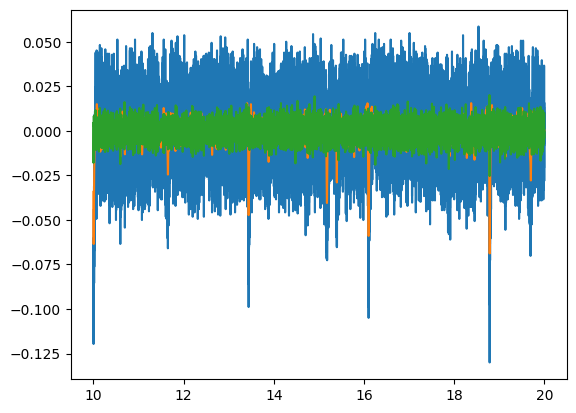

In [7]:
in0 = my_abf.sweepY
time = my_abf.sweepX


fig,ax=plt.subplots()


t_condit = np.logical_and(time>10,time<20)

sub_y = in0[t_condit]
sub_x = time[t_condit]

ax.plot(sub_x,sub_y)

b, a = scipy.signal.butter(2, [4,60], btype='bandpass',fs=10000)
y_filt = scipy.signal.filtfilt(b, a, sub_y)
ax.plot(sub_x,y_filt)

b, a = scipy.signal.butter(2, [60,250], btype='bandpass',fs=10000)
y_filt = scipy.signal.filtfilt(b, a, sub_y)
ax.plot(sub_x,y_filt)


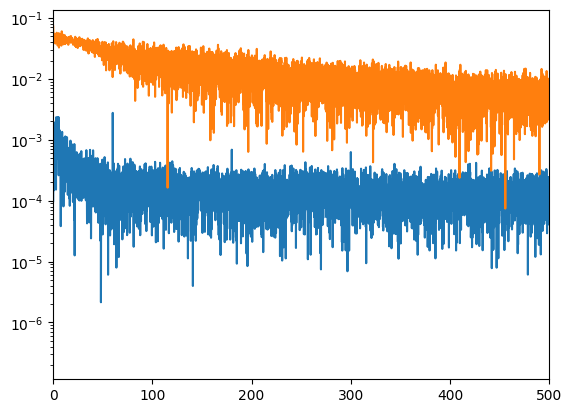

In [8]:
from scipy.fft import fft, fftfreq

N = len(sub_x)
T = 1/10000

yf = fft(sub_y)
xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax.grid()
ax.set_xlim(0,500)
ax.set_yscale('log')

prerip_t_condit = np.logical_and(time-.1>13.4,time-.1<13.5)
yf = fft(in0)
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax.grid()
ax.set_xlim(0,500)
ax.set_yscale('log')

In [9]:
from scipy import signal
fs = 10000
w = 6.
top_freq = fs/2
top_freq = 300
freq = np.linspace(1, top_freq, 100)
freq = np.logspace(np.log2(10), np.log2(top_freq), num=100, endpoint=True, base=2)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(sub_y, signal.morlet2, widths, w=w)

cw_abs = np.abs(cwtm)
cw_mean = np.expand_dims(np.mean(cw_abs,axis=1),-1)
cw_std = np.expand_dims(np.std(cw_abs,axis=1),-1)
cw_z = (cw_abs - cw_mean) / cw_std

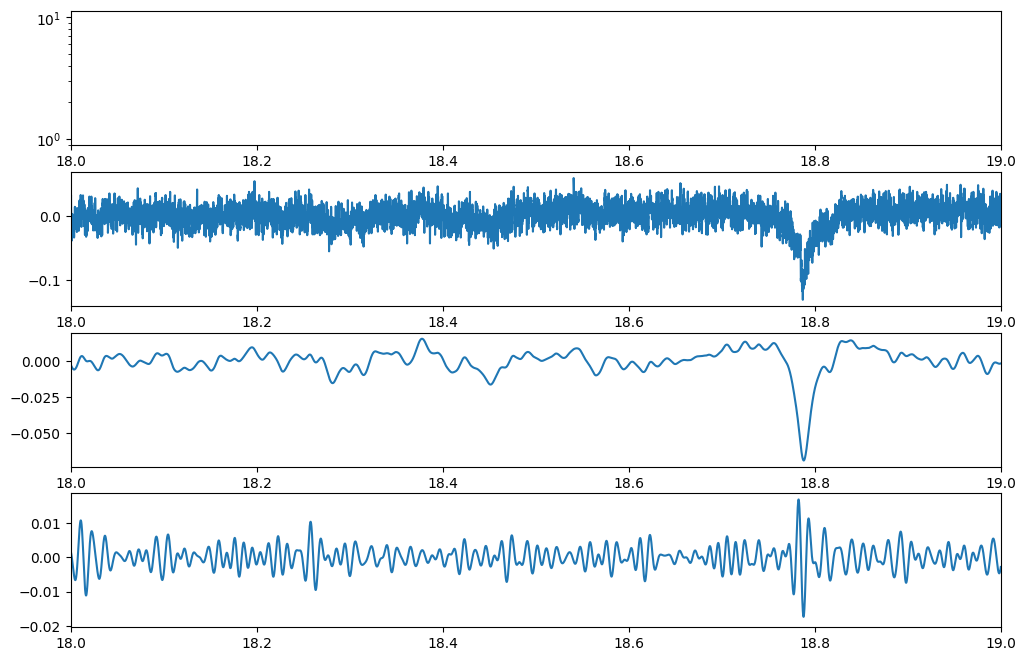

In [22]:
fig,ax=plt.subplots(4,1, figsize=(12,8))
ax=ax.flatten()
# cb = ax[0].pcolormesh(sub_x,freq,cw_z,cmap='hot')
ax[0].set_yscale('log')
# fig.colorbar(cb,ax=ax[0])


b, a = scipy.signal.butter(2, [4,60], btype='bandpass',fs=10000)
gamma_band = scipy.signal.filtfilt(b, a, sub_y)
b, a = scipy.signal.butter(4, [60,120], btype='bandpass',fs=10000)
ripple_band = scipy.signal.filtfilt(b, a, sub_y)

ax[1].plot(sub_x,sub_y)
ax[2].plot(sub_x,gamma_band)
ax[3].plot(sub_x,ripple_band)
for a in ax:
    a.set_xlim([18,19])

[      0   13428   20544 ... 4218049 4223640 4232811]


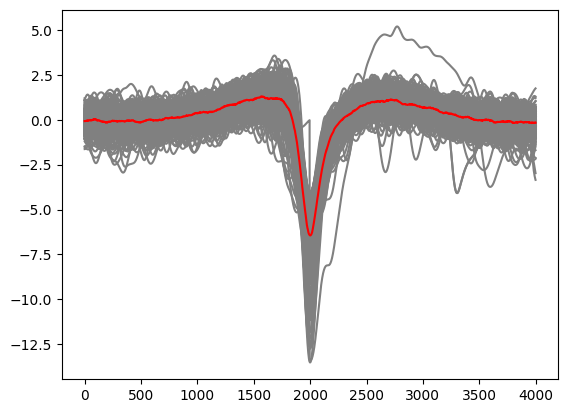

In [79]:
b, a = scipy.signal.butter(2, [4,60], btype='bandpass',fs=10000)
gamma_band = scipy.signal.filtfilt(b, a, in0)
gamma_band_z = z_trans(gamma_band)
trig = np.diff(gamma_band_z<-4,prepend=0)==1

trig_ind = np.where(trig)[0]
print(trig_ind)


wave_list = []
trig_ind_peaks = []
for t in trig_ind:
    try:
        prepend = 2000
        append = 2000
        sub_x = np.arange(t-prepend,t+append)
        sub_y = gamma_band_z[sub_x]
        min_ind = np.where(sub_y==np.min(sub_y))[0][0]
        t_adj=t+(min_ind-prepend)
        sub_x = np.arange(t_adj-prepend,t_adj+append)
        sub_y = gamma_band_z[sub_x]
        wave_list.append(sub_y)
        trig_ind_peaks.append(t_adj)
    except: None

waves = np.stack(wave_list)
fig,ax=plt.subplots()
ax.plot(waves.T,color='grey',zorder=-1)
ax.plot(np.median(waves,axis=0),'r',zorder=999)
plt.show()

In [67]:
np.mean(waves,axis=1)

array([ 0.5506,  0.0145,  0.0362, ..., -0.0179,  0.0633,  0.0564])

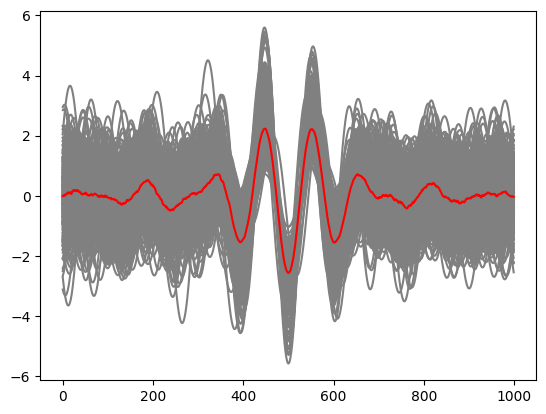

In [78]:

b, a = scipy.signal.butter(4, [70,120], btype='bandpass',fs=10000)
ripple_band = scipy.signal.filtfilt(b, a, in0)
ripple_band_z= z_trans(ripple_band)


rip_list = []
for t in trig_ind_peaks:
    prepend = 500
    append = 500
    sub_x = np.arange(t-prepend,t+append)
    sub_y = ripple_band_z[sub_x]

    extrema_ind = np.where(sub_y==np.min(sub_y))[0][0]
    t_adj=t+(extrema_ind-prepend)
    sub_x = np.arange(t_adj-prepend,t_adj+append)
    sub_y = ripple_band_z[sub_x]

    rip_list.append(sub_y)

rips = np.stack(rip_list)

fig,ax=plt.subplots()
ax.plot(rips.T,color='grey')
ax.plot(np.median(rips,axis=0),'r',zorder=999)
plt.show()